# Trajectory Analysis

Based on outputs from an [implementation of YOLOv7-SORT](https://github.com/RizwanMunawar/yolov7-object-tracking).

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as pat
import os

#### Import Tracks and Video

In [2]:
os.chdir('./yolov7-object-tracking/runs/detect')
os.listdir()

['object_tracking9',
 'object_tracking7',
 'object_tracking6',
 'object_tracking8',
 '.DS_Store',
 'object_tracking10',
 'object_tracking',
 'object_tracking11',
 'object_tracking4',
 'object_tracking3',
 'object_tracking2',
 'object_tracking5',
 'object_tracking13',
 'object_tracking12']

In [3]:
run_to_analyze = "object_tracking12"
os.chdir(os.path.join(os.getcwd(), run_to_analyze))

os.listdir()

['.DS_Store', 'labels', 'videoplayback_original.mp4', 'videoplayback (1).mp4']

In [4]:
VIDEO_FNAME = os.listdir()[2]

In [5]:
# Read all labels
os.chdir("./labels")

frames_trk_dets = os.listdir()
frames_trk_dets.sort(key=lambda e: e.split("_")[1].split(".")[0])

frame_dets = []
for frame in frames_trk_dets:
    frame_preds = ""
    with open(frame, "r") as f:
        dets = f.readlines()
    
    # VehicleID, Vehicle Class, Centroid_X, Centroid_Y, Bbox_W, Bbox_H
    ds = []
    for d in dets:
        d = d[:-1]
        d = d.split(" ")
        ds.append([int(d[0]), int(d[1]), float(d[2]), float(d[3]), float(d[4]), float(d[5])])
    frame_dets.append(ds)

(480, 854, 3)


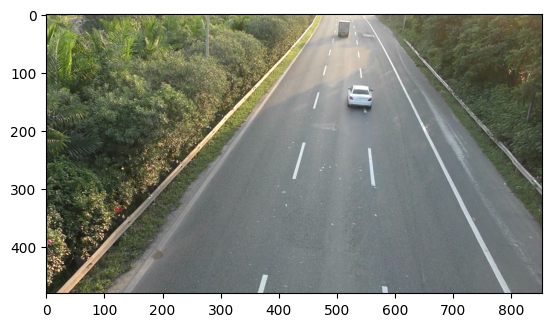

In [6]:
# Grab a frame from the video
os.chdir("..")

vidcap = cv2.VideoCapture(VIDEO_FNAME)
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 1000)

_, img = vidcap.read()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
print(img_rgb.shape)

In [7]:
MAX_VEHICLE_ID = 1177

## Definition of Operational Area

Due to the scope of this project, we will only define an operational area where our algorithm will work.

In [216]:
operational_y_max = 480
operational_y_min = 150
operational_x_max = 800
operational_x_min = 100

Operational area:


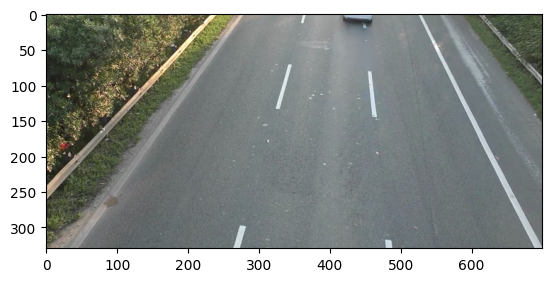

In [217]:
print("Operational area:")
plt.imshow(img_rgb[operational_y_min:operational_y_max, operational_x_min:operational_x_max])

## Attempt to Draw Lines

First, generate a line by getting all centroids for each vehicle ID.

In [218]:
def is_id_in_frame(vehicle_id, frame) -> bool:
    for dets in frame:
        if dets[0] == vehicle_id:
            return True
    return False

vehicle_lines = []
for vehicle_id in range(MAX_VEHICLE_ID):
    # Grab all of id's centroids
    # Grab frames where vehicle_id is present
    present_frames = list(filter(lambda x: is_id_in_frame(vehicle_id, x), frame_dets))
    
    # For all the frames where the vehicle is present, generate a list of points
    centroids_x = []
    centroids_y = []
    bounding_boxes = []
    for pf in present_frames:
        for dets in pf:
            if dets[0] == vehicle_id:
                # Check if within constraints
                x_denormalized = dets[2] * img_rgb.shape[1]
                y_denormalized = dets[3] * img_rgb.shape[0]
                # if operational_y_min <= y_denormalized <= operational_y_max and operational_x_min <= x_denormalized <= operational_x_max:
                centroids_x.append(x_denormalized)
                centroids_y.append(y_denormalized)
                bounding_boxes.append([dets[4] * img_rgb.shape[1], dets[5] * img_rgb.shape[0]])
    vehicle_lines.append({
        "v_id": vehicle_id,
        "x_coords": centroids_x,
        "y_coords": centroids_y,
        "bbox": bounding_boxes
    })

Second, now that we have the lines as a collection of centroids, we can draw them onto the plot.

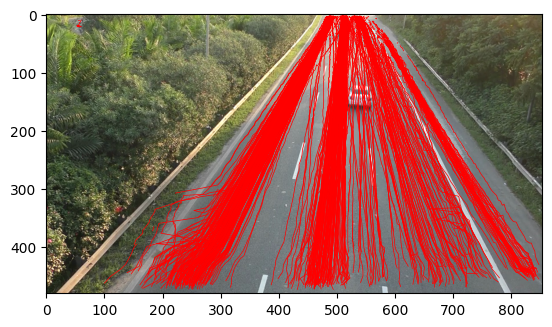

In [219]:
for line in vehicle_lines:
    x = line["x_coords"]
    y = line["y_coords"]
    plt.plot(x, y, color="red", linewidth=0.5)

plt.imshow(img_rgb)
plt.show()

## Performing Clutering of Trajectories

After feature extraction, which for our case is the extraction of trajectories, we now need to apply clustering to figure out lane centroids.

There are two ideas for this:
1. KMeans everything right out of the box (all centroids are involved in the clustering).
2. DBSCAN Clutering

First, let's transform the trajectory information to follow the format that we need it to be (based on `sklearn`). Then, if data cleaning is necessary, then we clean the data.

In [220]:
# Transform Centroid Points into a Numpy Matrix of (x, y)
centroids_arr = []
for line in vehicle_lines:
    x = line["x_coords"]
    y = line["y_coords"]
    for i in range(len(x)):
        centroids_arr.append([line["v_id"], x[i],y[i], line["bbox"][i][0], line["bbox"][i][1]])
len(centroids_arr)

90115

In [221]:
centroids = np.array(centroids_arr)
centroids

array([[   0.      ,  341.999672,  276.      ,  190.371118,   54.51984 ],
       [   0.      ,  378.000042,  212.00016 ,  151.228882,   43.27872 ],
       [   0.      ,  378.000042,  212.00016 ,  151.228882,   43.27872 ],
       ...,
       [1176.      ,  506.000124,   62.00016 ,   46.258618,   14.6136  ],
       [1176.      ,  506.000124,   60.99984 ,   44.478882,   14.6136  ],
       [1176.      ,  506.000124,   60.      ,   44.478882,   13.48944 ]])

### Formatting & Visualizing the Bounding Boxes

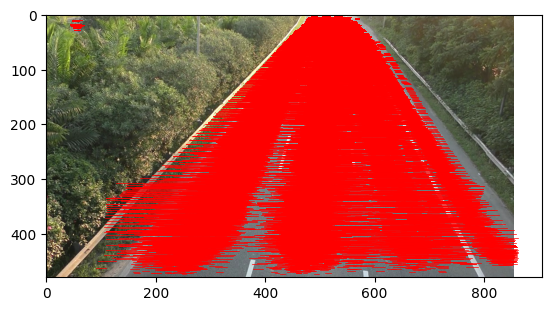

In [222]:
fig, ax = plt.subplots(1)

ax.imshow(img_rgb)
for i in range(0, centroids.shape[0]):
    # Maybe better if we represent as lines instead?
    x = [centroids[i,1] - (centroids[i,4]/2), centroids[i,1] + (centroids[i,4]/2)]
    y = [centroids[i,2] for _ in range(len(x))]
    ax.plot(x, y, linewidth=0.5, color="r")
    # ---
    # Set it such that the centroid is the center of the rectangle
    # x = centroids[i,0] - (bbox[i,1] / 2)
    # y = centroids[i,1] - (bbox[i,0] / 2)
    # rect = pat.Rectangle((x, y), bbox[i,1], bbox[i,0], linewidth=0.1, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
plt.show()

### Perform Operational Area Filtering

In [223]:
filtered_centroids = []
for i in range(centroids.shape[0]):
    if operational_y_min <= centroids[i,2] <= operational_y_max and operational_x_min <= centroids[i,1] <= operational_x_max:
        filtered_centroids.append(centroids[i])
        
filtered_centroids = np.array(filtered_centroids)
filtered_centroids

array([[   0.      ,  341.999672,  276.      ,  190.371118,   54.51984 ],
       [   0.      ,  378.000042,  212.00016 ,  151.228882,   43.27872 ],
       [   0.      ,  378.000042,  212.00016 ,  151.228882,   43.27872 ],
       ...,
       [1176.      ,  490.999614,  159.      ,   85.4     ,   27.54096 ],
       [1176.      ,  490.999614,  159.      ,   85.4     ,   27.54096 ],
       [1176.      ,  491.999648,  152.00016 ,   85.4     ,   26.97888 ]])

### Density Level Filtering

This is done to prevent excessive centroid densities that will inhibit the performance of the clustering algorithms.

In [224]:
keep_percentage = 1
original_n = filtered_centroids.shape[0]
keep_n = int(np.round(filtered_centroids.shape[0] * keep_percentage))

filtered_centroids = filtered_centroids[0:keep_n, :]

print("Old n: {n_old}, New n: {n_new}".format(n_old=original_n, n_new=filtered_centroids.shape[0]))

Old n: 20691, New n: 20691


### Visualizing the Data for Data Cleaning

Here, we check the trajectories if there are any specific trajectories that we need to eliminate and clean out. These are outliers or trajectories that distort.

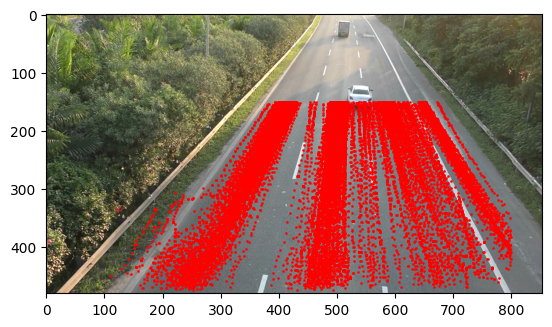

In [225]:
plt.imshow(img_rgb)
plt.scatter(filtered_centroids[:, 1], filtered_centroids[:, 2], linewidth=0.1, color="red", s=3)

In [226]:
# Cleaning here if necessary

### Clustering Using SKLearn's KMeans Clustering

#### Idea 1: Just Cluster it Naivëly

In [227]:
from sklearn.cluster import KMeans
from matplotlib import colors as mpl_colors

In [232]:
model = KMeans(n_clusters=9)
clustered = model.fit(filtered_centroids[:, [1,2]])
cluster_centers = clustered.cluster_centers_
cluster_centers

array([[396.62121609, 187.45055751],
       [714.99334557, 382.79349947],
       [259.50053515, 410.09266707],
       [623.80257996, 186.22941567],
       [496.12982915, 289.01806973],
       [503.85134099, 191.10957843],
       [342.05441327, 290.08787107],
       [486.15302844, 410.99140841],
       [671.95269154, 271.35210673]])

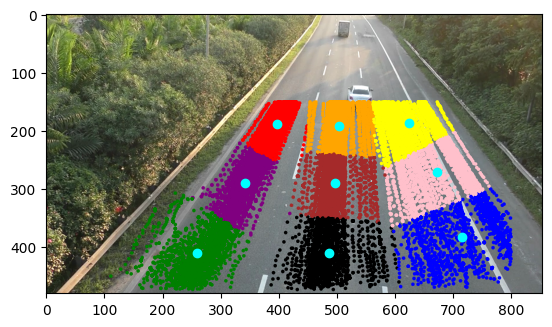

In [233]:
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "black", "pink"]
plt.imshow(img_rgb)
plt.scatter(filtered_centroids[:, 1], filtered_centroids[:, 2], linewidth=0.1, c=clustered.labels_, cmap=mpl_colors.ListedColormap(color_map), s=6)
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], color="cyan")
plt.show()

This is terrible.

#### Idea 2: DBSCAN Clustering?

In [34]:
from sklearn.cluster import DBSCAN
from matplotlib import colors as mpl_colors

In [35]:
model = DBSCAN(eps=32, min_samples=128)
clustered = model.fit(filtered_centroids[:, [1,2]])

In [36]:
components = clustered.components_
clustered_labels = clustered.labels_
clustered_labels.shape, components.shape

((6938,), (6078, 2))

In [37]:
np.max(clustered_labels), np.min(clustered_labels)

(2, -1)

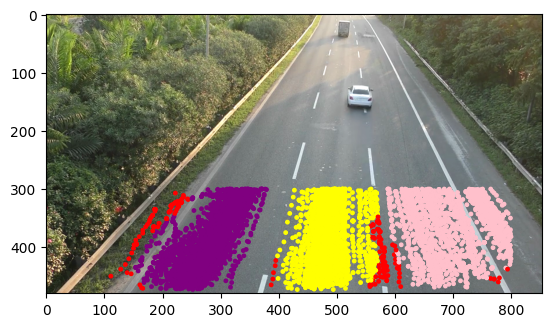

In [40]:
# Plot components per cluster
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "black", "pink"]
plt.imshow(img_rgb)
plt.scatter(filtered_centroids[:,1], filtered_centroids[:,2], c=clustered_labels, cmap=mpl_colors.ListedColormap(color_map), s=6)
plt.show()

I think this could work well if we dive deeper and modify the algorithm to handle cases of varying density, such as presented in the image above. We can see that the lanes start at different trajectory groups, but converge into one big cluster as we get closer to the vanishing point. This big cluster will inevitably throw off the DBSCAN algorithm.

#### Idea 3: OPTICS Clustering?

In [41]:
from sklearn.cluster import OPTICS
from matplotlib import colors as mpl_colors

In [42]:
optics_model = OPTICS(min_samples=128, max_eps=32)
optics_clustered = optics_model.fit(filtered_centroids[:, [1,2]])

In [43]:
optics_clustered_labels = optics_clustered.labels_
optics_clustered_labels.shape

(6938,)

In [44]:
np.max(optics_clustered_labels), np.min(optics_clustered_labels)

(2, -1)

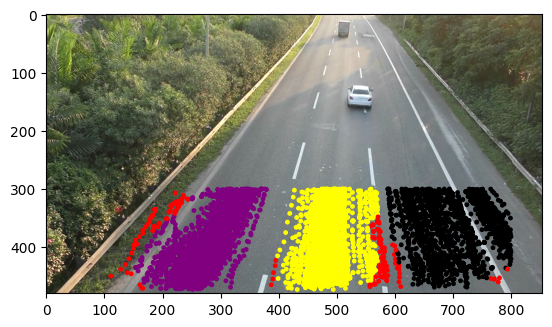

In [45]:
# Plot components per cluster
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]
plt.imshow(img_rgb)
plt.scatter(filtered_centroids[:,1], filtered_centroids[:,2], c=optics_clustered_labels, cmap=mpl_colors.ListedColormap(color_map), s=6)
plt.show()

#### Idea 5: Trajectory Clustering

## Lane Mask Generation

Now that we know the point clusters as well as their bounding box dimensions, we can project these clusters into their respective trajectories and extend the mask to the vanishing point.

For each cluster, we need to find their trajectories (i.e. which trajectories their centroids belong to) and tag them with the cluster ID.

But first, let's visualize just this section with their bounding boxes.

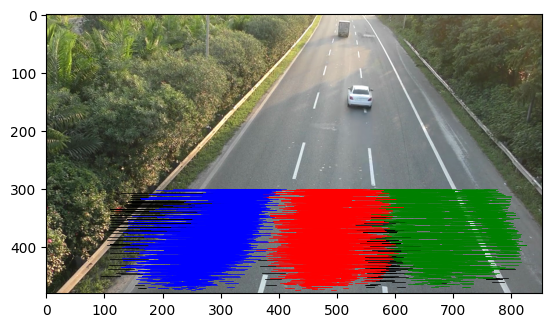

In [47]:
fig, ax = plt.subplots(1)
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]
ax.imshow(img_rgb)
for i in range(0, filtered_centroids.shape[0]):
    # Maybe better if we represent as lines instead?
    x = [filtered_centroids[i,1] - (filtered_centroids[i,4] / 2), filtered_centroids[i,1] + (filtered_centroids[i,4] / 2)]
    y = [filtered_centroids[i,2] for _ in range(len(x))]
    ax.plot(x, y, linewidth=0.5, color=color_map[optics_clustered_labels[i]])
    # ---
    # Set it such that the centroid is the center of the rectangle
    # x = centroids[i,0] - (bbox[i,1] / 2)
    # y = centroids[i,1] - (bbox[i,0] / 2)
    # rect = pat.Rectangle((x, y), bbox[i,1], bbox[i,0], linewidth=0.1, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
plt.show()

### Trajectory Mapping

Now we find the trajectories that these clustered points belong to.

In [55]:
filtered_centroids

array([[   8.      ,  461.000302,  471.      ,  179.696118,    9.55488 ],
       [   8.      ,  464.999584,  464.00016 ,  224.175   ,   17.98608 ],
       [   8.      ,  466.999652,  453.      ,  217.058618,   28.66512 ],
       ...,
       [1174.      ,  464.999584,  356.00016 ,  154.7875  ,   56.20608 ],
       [1174.      ,  464.999584,  356.00016 ,  154.7875  ,   56.20608 ],
       [1174.      ,  464.999584,  356.00016 ,  154.7875  ,   56.20608 ]])

In [56]:
# For all centriods, append cluster assignments
missing_trajectories = 0
cluster_assignments = np.empty((filtered_centroids.shape[0], 1))
for i in range(len(filtered_centroids)):
    cluster_assignments[i] = optics_clustered_labels[i]
    
clustered_centroids = np.append(filtered_centroids, cluster_assignments, axis=1)
clustered_centroids

array([[   8.      ,  461.000302,  471.      ,  179.696118,    9.55488 ,
           0.      ],
       [   8.      ,  464.999584,  464.00016 ,  224.175   ,   17.98608 ,
           0.      ],
       [   8.      ,  466.999652,  453.      ,  217.058618,   28.66512 ,
           0.      ],
       ...,
       [1174.      ,  464.999584,  356.00016 ,  154.7875  ,   56.20608 ,
           0.      ],
       [1174.      ,  464.999584,  356.00016 ,  154.7875  ,   56.20608 ,
           0.      ],
       [1174.      ,  464.999584,  356.00016 ,  154.7875  ,   56.20608 ,
           0.      ]])

In [77]:
# Separate into different clusters
clusters = []
for i in range(int(np.max(clustered_centroids[:,5]) + 1)):
    c = []
    for j in range(clustered_centroids.shape[0]):
        if clustered_centroids[j,5] == i:
            c.append(clustered_centroids[j])
    clusters.append(np.array(c))
            
for cluster in clusters:
    print(len(cluster))

2431
2575
1746


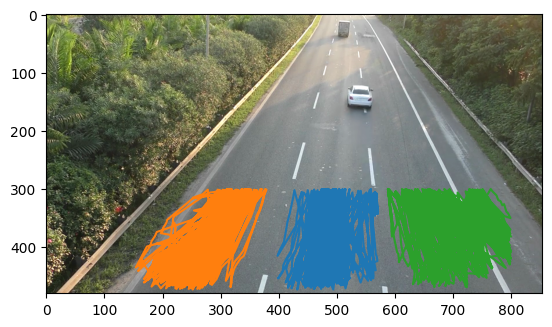

In [81]:
# Visualize Trajectories
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]

for i in range(len(clusters)):
    cluster_centroids = clusters[i]
    plt.plot(cluster_centroids[:,1], cluster_centroids[:,2])

plt.imshow(img_rgb)
plt.show()

In [99]:
# Propagate the clusters to the original trajectories

def is_v_id_in_cluster(v_id, cluster):
    # Linear searching
    for arr in cluster:
        if arr[0] == v_id:
            return True
    return False

all_centroid_assignments = np.empty((centroids.shape[0], 1))
for i in range(centroids.shape[0]):
    for c in range(len(clusters)):
        if is_v_id_in_cluster(centroids[i,0], clusters[c]):
            all_centroid_assignments[i] = c
            break
all_centroids = np.append(centroids, all_centroid_assignments, axis=1)
all_centroids

array([[   0.      ,  341.999672,  276.      ,  190.371118,   54.51984 ,
           0.      ],
       [   0.      ,  378.000042,  212.00016 ,  151.228882,   43.27872 ,
           0.      ],
       [   0.      ,  378.000042,  212.00016 ,  151.228882,   43.27872 ,
           0.      ],
       ...,
       [1176.      ,  506.000124,   62.00016 ,   46.258618,   14.6136  ,
           0.      ],
       [1176.      ,  506.000124,   60.99984 ,   44.478882,   14.6136  ,
           0.      ],
       [1176.      ,  506.000124,   60.      ,   44.478882,   13.48944 ,
           0.      ]])

In [100]:
# Separate projected trajectories into different clusters
projected_clusters = []
for i in range(int(np.max(all_centroids[:,5]) + 1)):
    c = []
    for j in range(all_centroids.shape[0]):
        if all_centroids[j,5] == i:
            c.append(all_centroids[j])
    projected_clusters.append(np.array(c))
            
for cluster in projected_clusters:
    print(len(cluster))

49592
24881
15642


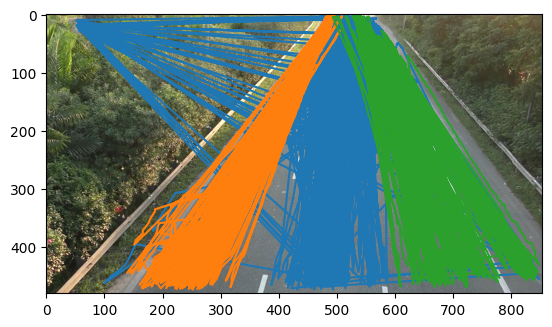

In [101]:
# Visualize ALL projected trajectories
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]

for i in range(len(projected_clusters)):
    cluster_centroids = projected_clusters[i]
    plt.plot(cluster_centroids[:,1], cluster_centroids[:,2])

plt.imshow(img_rgb)
plt.show()

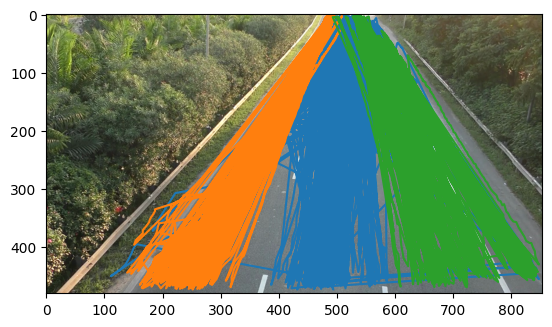

In [235]:
# Filter outlier trajectories and re-visualize
left_bound = 100

for c in range(len(projected_clusters)):
    cluster = projected_clusters[c]
    cluster = cluster[cluster[:, 1] >= left_bound]
    projected_clusters[c] = cluster

# Visualize ALL projected trajectories
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]

for i in range(len(projected_clusters)):
    cluster_centroids = projected_clusters[i]
    plt.plot(cluster_centroids[:,1], cluster_centroids[:,2])

plt.imshow(img_rgb)
plt.show()

We have the assumption that all of these trajectories are of approximate length relative to each other. The basis of this assumption is that all vehicles take the same set of paths. Hence, it may be safe to extract some centroid points from these trajectories for aggregation using a normalized percentage value.

In [142]:
# Sort into lines per cluster
sorted_clusters = []

for cluster in projected_clusters:
    lines = []
    for i in range(int(np.max(cluster[:,0])) + 1):
        line = cluster[cluster[:,0] == i]
        lines.append(line)
    sorted_clusters.append(lines)

In [143]:
# Sort by y-value
for c in range(len(sorted_clusters)):
    for l in range(len(sorted_clusters[c])):
        # Sort line
        sorted_clusters[c][l] = np.flip(sorted_clusters[c][l][sorted_clusters[c][l][:, 2].argsort()], axis=0)

In [196]:
# Aggregate all Trajectories into one trajectory per cluster
fine_aggregation_coefficient = 60
query_centroids = np.linspace(0, 1, num=fine_aggregation_coefficient)
aggregated_trajectories = []

print(aggregated_trajectories, "<----= Initialized trajectories list")

print(query_centroids, "<----= Centroid Query Points")

for c in range(len(sorted_clusters)):
    cluster_agg = []
    for i in range(fine_aggregation_coefficient):
        n_points = 0
        sum_x = 0
        sum_y = 0
        sum_bbox_len = 0
        for l in range(len(sorted_clusters[c])):
            if sorted_clusters[c][l].shape[0] > 0:
                bbox_weights = sorted_clusters[c][l][int(sorted_clusters[c][l].shape[0] * query_centroids[i]) - 1, 2] / sorted_clusters[c][l][0,2]
                sum_x += sorted_clusters[c][l][int(sorted_clusters[c][l].shape[0] * query_centroids[i]) - 1, 1]
                sum_y += sorted_clusters[c][l][int(sorted_clusters[c][l].shape[0] * query_centroids[i]) - 1, 2]
                sum_bbox_len += sorted_clusters[c][l][int(sorted_clusters[c][l].shape[0] * query_centroids[i]) - 1, 3] * bbox_weights
                n_points += 1
        cluster_agg.append([sum_x/n_points, sum_y/n_points, sum_bbox_len/n_points])
    aggregated_trajectories.append(cluster_agg)

[] <----= Initialized trajectories list
[0.         0.01694915 0.03389831 0.05084746 0.06779661 0.08474576
 0.10169492 0.11864407 0.13559322 0.15254237 0.16949153 0.18644068
 0.20338983 0.22033898 0.23728814 0.25423729 0.27118644 0.28813559
 0.30508475 0.3220339  0.33898305 0.3559322  0.37288136 0.38983051
 0.40677966 0.42372881 0.44067797 0.45762712 0.47457627 0.49152542
 0.50847458 0.52542373 0.54237288 0.55932203 0.57627119 0.59322034
 0.61016949 0.62711864 0.6440678  0.66101695 0.6779661  0.69491525
 0.71186441 0.72881356 0.74576271 0.76271186 0.77966102 0.79661017
 0.81355932 0.83050847 0.84745763 0.86440678 0.88135593 0.89830508
 0.91525424 0.93220339 0.94915254 0.96610169 0.98305085 1.        ] <----= Centroid Query Points


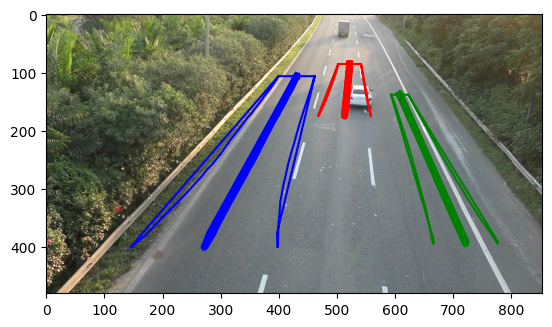

In [200]:
# Visualize Lane Tendency
color_map = ["red", "blue", "green", "yellow", "brown", "orange", "purple", "pink", "black"]

for i in range(len(aggregated_trajectories)):
    c = np.array(aggregated_trajectories[i])
    # Construct bounding points
    left_bounds = c[:,0] - (c[:,2]/2)
    right_bounds = c[:,0] + (c[:,2]/2)
    left_bound_points = np.stack([left_bounds, c[:,1]], axis=1)
    right_bound_points = np.stack([right_bounds, c[:,1]], axis=1)
    polygon_keypoints = np.concatenate([left_bound_points, right_bound_points])
    plt.plot(polygon_keypoints[:,0], polygon_keypoints[:,1], color=color_map[i], linewidth=1.5)
    plt.plot(c[:,0], c[:,1], color=color_map[i], linewidth=5)

# for traj in aggregated_trajectories:
#     for line in traj:
#         x = line["x_coords"]
#         y = line["y_coords"]
#         plt.plot(x, y, color=color_map[line["lane_cluster"]], linewidth=0.5)
    
plt.imshow(img_rgb)
plt.show()

## Drawing Lane Masks Using Polygons

Using the aggregated trajectory and bounding box representatives for each cluster as shown above, we can use the aggregated bounding boxes to compile polygon points.